# Lab Vision Sytems: Session 4

# Today:

### 1: Solution Assignment 3
### 2: Unsupervised Learning & Autoencoders
### 3: Denoising Autoencoders
### 4: Variational Autoencoders

In [1]:
import torch
print(torch.cuda.is_available())

True


# 0: Some comments

### Change in Class Date

#### Session 8 will take place on 09.07 instead of 16.07

### Reloading External Code

In [ ]:
%load_ext autoreload
%autoreload 2

### Importance of Initialization

<img src="imgs/lstm_unnorm.png" width=45%/>  <img src="imgs/lstm.png" width=44.5%/>

In [2]:
batch_size = 32
hidden_size = 16
input_size = 16

x = torch.rand(batch_size, input_size) * 2 - 1  # [-1, 1]
h = torch.rand(batch_size, hidden_size) * - 1  # [-1, 1]
input_combined = torch.cat((x, h), dim=1)

In [3]:
unnorm_layer = torch.randn(hidden_size, hidden_size + input_size)
y = input_combined @ unnorm_layer.T

xavier_layer = torch.randn(hidden_size, hidden_size + input_size) * 2 / (2 * hidden_size + input_size)
y_xav = input_combined @ xavier_layer.T

In [4]:
print("Values in Random Init Model")
print(f"  Max:  {round(y.max().item(), 3)}")
print(f"  Min:  {round(y.min().item(), 3)}")
print(f"  Mean: {round(y.mean().item(), 3)}")
print(f"  Std:  {round(y.std().item(), 3)}")

Values in Random Init Model
  Max:  10.398
  Min:  -9.227
  Mean: 0.439
  Std:  3.263


In [5]:
print("Values in Xavier Init Model")
print(f"  Max:  {round(y_xav.max().item(), 3)}")
print(f"  Min:  {round(y_xav.min().item(), 3)}")
print(f"  Mean: {round(y_xav.mean().item(), 3)}")
print(f"  Std:  {round(y_xav.std().item(), 3)}")

Values in Xavier Init Model
  Max:  0.402
  Min:  -0.506
  Mean: 0.012
  Std:  0.142


# 1: Solution Assignment 3

By Aidin, Moein and Amir

# 2: Autoencoders 

# 3: Denoising Autoencoders

In [6]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

from torch.utils.tensorboard import SummaryWriter

In [7]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "vanilla_dae")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

In [8]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/vanilla_dae"):
    os.makedirs("imgs/vanilla_dae")
if not os.path.exists("imgs/convAE"):
    os.makedirs("imgs/convAE")
if not os.path.exists("imgs/vanilla_vae"):
    os.makedirs("imgs/vanilla_vae")

In [10]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2)
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

In [11]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=B_SIZE, 
        shuffle=True,
        num_workers=2  # what is this?
) 
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, 
        batch_size=B_SIZE,
        shuffle=False,
        num_workers=2  # what is this?
)

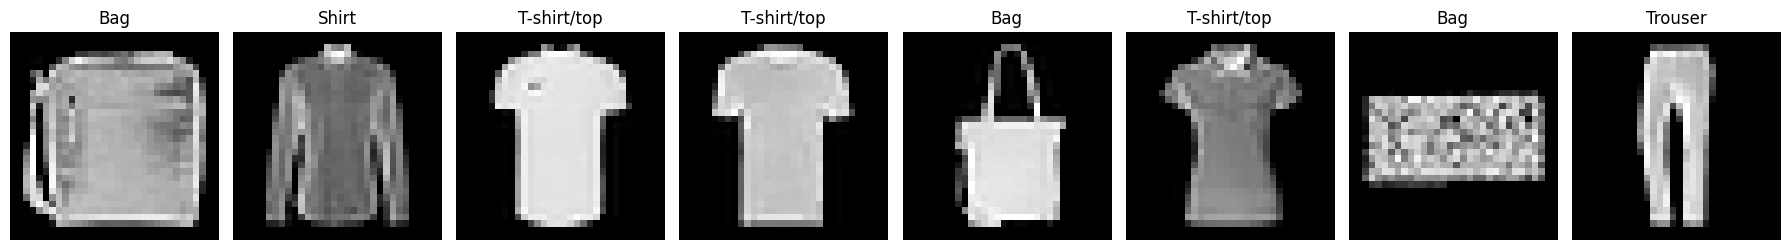

In [12]:
imgs, labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[i].imshow(imgs[i, 0], cmap="gray")
    ax[i].axis("off")
    ax[i].set_title(f"{train_dataset.classes[labels[i]]}")
plt.tight_layout()
plt.show()

## Model

In [13]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()
    
def get_dropout(drop_p):
    """ Getting a dropout layer """
    if(drop_p):
        drop = nn.Dropout(p=drop_p)
    else:
        drop = nn.Identity()
    return drop

class Reshape(nn.Module):
    """ Module for reshaping a tensor"""
    def __init__(self, size):
        """ Module initializer"""
        super().__init__()
        self.size = size
        
    def forward(self,x):
        """ Rehaping channel spatial dimension"""
        y = x.view(-1, *self.size)
        return y

In [14]:
class VanillaAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1, 32, 32), sizes=[1024, 128, 10], act="ReLU", dropout_in=0.2, dropout_hid=0.5):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.dropout_in = dropout_in
        self.dropout_hid = dropout_hid
        self.activation = get_act(act) 
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-1):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append(self.activation)
            if(i == 0):
                layers.append(get_dropout(self.dropout_in))
            else:
                layers.append(get_dropout(self.dropout_hid))

        # replacing last act and dropout with tanh
        layers = layers[:-2] + [nn.Tanh()]  # why TanH?
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
            layers.append(get_dropout(self.dropout_hid))
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-2] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    def forward(self, x):
        """ Forward pass """
        x_flat = x.flatten(start_dim=1)
        z = self.encoder(x_flat)
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        return x_hat, z

In [15]:
ae = VanillaAE(in_size=(1, 32, 32), sizes=[1024, 128, 10])

In [16]:
ae

VanillaAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1024, bias=True)
    (4): Sigmoid()
  )
)

## Utils

In [17]:
def add_noise(img, mean=0, sigma=0.3):
    """ Adding AWGN to images"""
    noisy_img = img + torch.normal(mean * torch.ones(img.shape), sigma).to(img.device)
    return noisy_img.clamp(0,1)

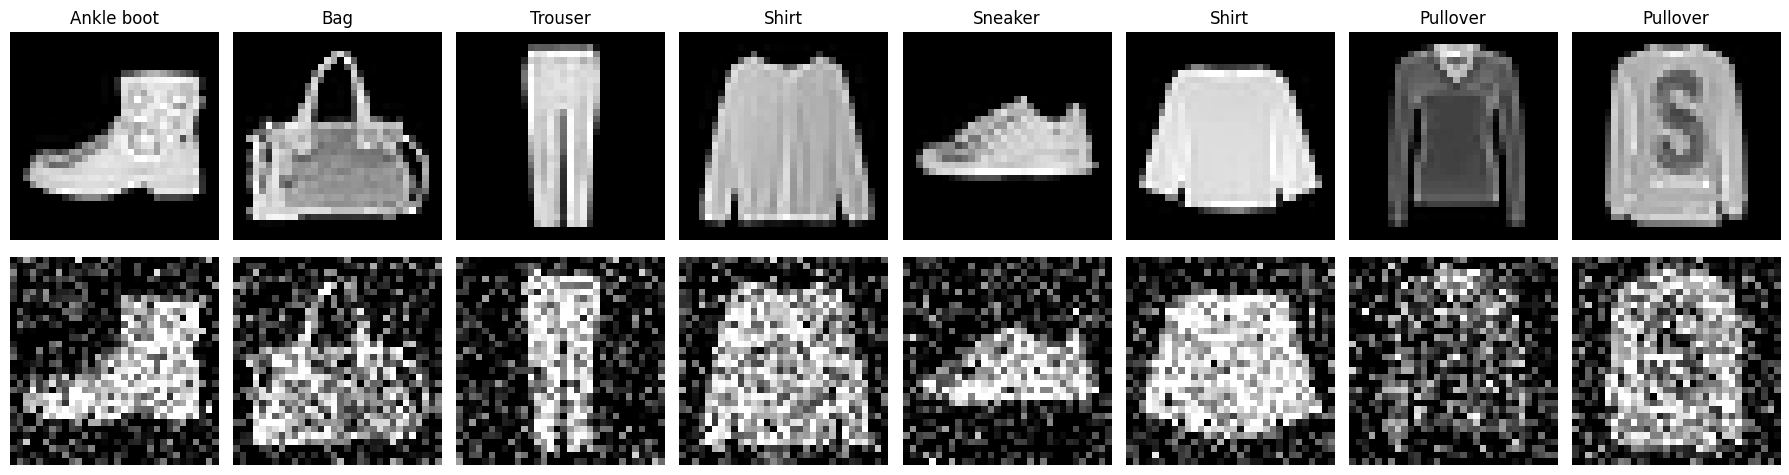

In [18]:
imgs, labels = next(iter(train_loader)) 
noisy_imgs = add_noise(imgs, sigma=0.3)
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[0, i].set_title(f"{train_dataset.classes[labels[i]]}")
    ax[1, i].imshow(noisy_imgs[i, 0], cmap="gray")
    ax[1, i].axis("off")
plt.tight_layout()
plt.show()

In [19]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        noisy_images = add_noise(images)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, _ = model(noisy_images)
         
        # Calculate Loss
        loss = criterion(recons, images)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None):
    """ Evaluating the model for either validation or test """
    loss_list = []
    
    for i, (images, _) in enumerate(eval_loader):
        noisy_images = add_noise(images)
        noisy_images = noisy_images.to(device)
        
        # Forward pass 
        recons, _ = model(noisy_images)
                 
        loss = criterion(recons.cpu(), images)
        loss_list.append(loss.item())
        
        if(i==0 and savefig):
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            save_image( images[:64].cpu(), os.path.join(savepath, f"input_{epoch}.png") )
            save_image( noisy_images[:64].cpu(), os.path.join(savepath, f"noisy_{epoch}.png") ) 
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            if writer is not None:
                grid = torchvision.utils.make_grid(images[:64].cpu())
                writer.add_image('images', grid, epoch)
                grid = torchvision.utils.make_grid(noisy_images[:64].cpu())
                writer.add_image('noisy_images', grid, epoch)
                grid = torchvision.utils.make_grid(recons[:64].cpu())
                writer.add_image('output_images', grid, epoch)
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    
    return loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, savepath, writer, save_frequency=5, vis_frequency=2):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % vis_frequency == 0 or epoch == num_epochs - 1)
        loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer
            )
        val_loss.append(loss)
        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch)
        writer.add_scalars(f'Loss/Comb', {"train": mean_loss.item(), "valid": loss.item()}, global_step=epoch)
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = CONFIG["random_seed"]
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [20]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

## Training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
ae = VanillaAE(in_size=(1,32,32), sizes=[1024, 512, 128, 64], act="ReLU", dropout_in=0.1, dropout_hid=0.3)
ae = ae.to(device)

In [23]:
ae.encoder

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): Tanh()
)

In [24]:
ae.decoder

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=1024, bias=True)
  (7): Sigmoid()
)

In [25]:
# count_model_params(ae)
print(f"Encoder has {count_model_params(ae.encoder)} params")
print(f"Decoder has {count_model_params(ae.decoder)} params")

Encoder has 598720 params
Decoder has 599680 params


In [28]:
model = ae

### If encoder and decoder are symetric, why this difference?

In [29]:
# regression loss function
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [30]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "vanilla_dae")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [31]:
savepath = "imgs/vanilla_dae"

train_loss, val_loss, loss_iters = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10,
        savepath=savepath, writer=writer
    )


stats = {
    "train_loss": train_loss,
    "valid_loss": val_loss,
    "loss_iters": loss_iters
}
save_model(model=model, optimizer=optimizer, epoch=20, stats=stats)

Epoch 1 Iter 235: loss 0.04208. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 61.49it/s]


    Train loss: 0.07127
    Valid loss: 0.18892


Epoch 3 Iter 235: loss 0.02596. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 62.71it/s]

    Train loss: 0.02768
    Valid loss: 0.02828



Epoch 5 Iter 235: loss 0.02274. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 60.90it/s]


    Train loss: 0.02332
    Valid loss: 0.02125


Epoch 7 Iter 235: loss 0.02374. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 64.00it/s]

    Train loss: 0.02179
    Valid loss: 0.01959



Epoch 9 Iter 235: loss 0.02111. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 62.92it/s]


    Train loss: 0.021
    Valid loss: 0.01877


Epoch 10 Iter 235: loss 0.02119. : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 62.38it/s]


    Train loss: 0.0207
    Valid loss: 0.01841
Training completed


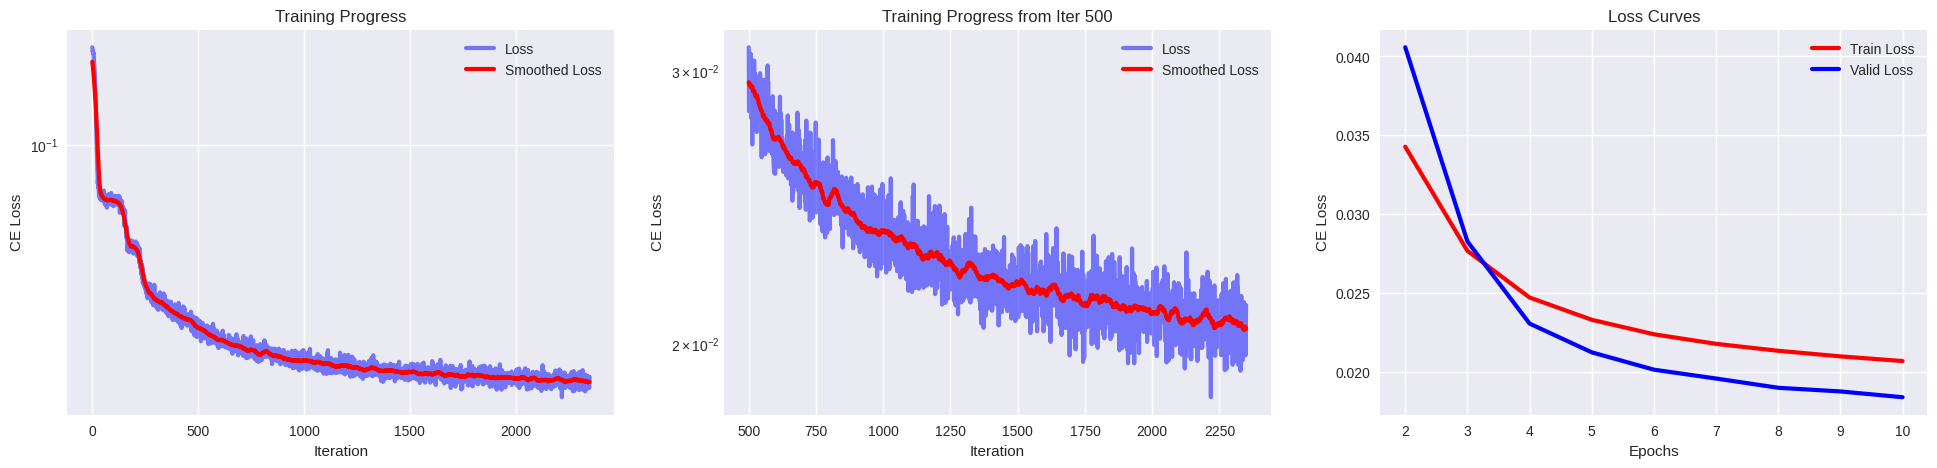

In [32]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(loss_iters, 31)
START = 500
N_ITERS = len(loss_iters)
ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()

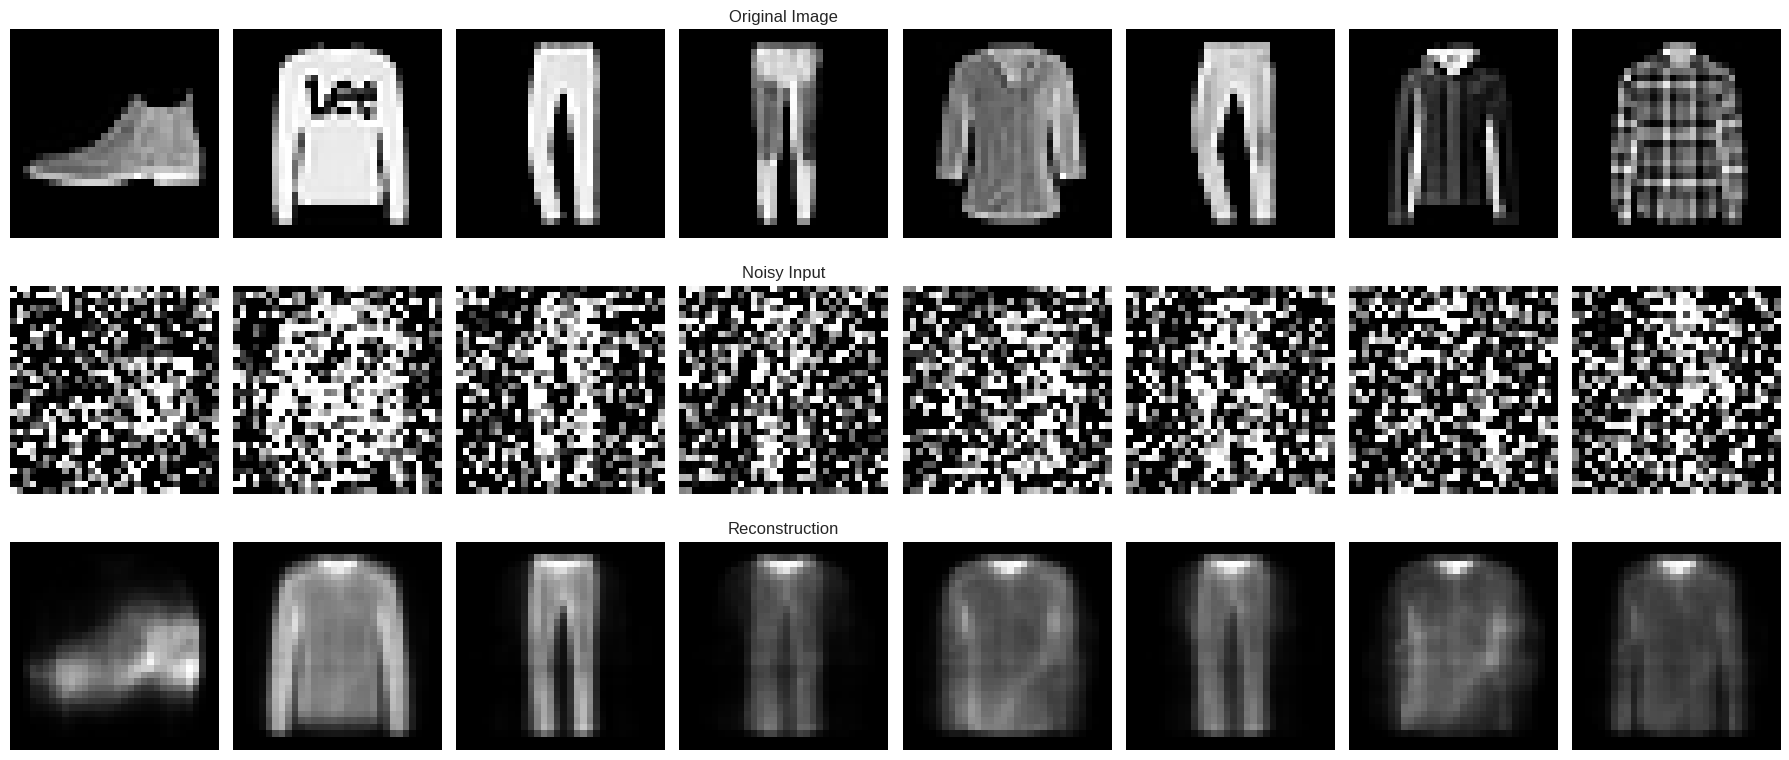

In [34]:
imgs, _ = next(iter(test_loader)) 
noisy_imgs = add_noise(imgs, sigma=0.8)

ae.eval()
with torch.no_grad():
    recons, _ = model(noisy_imgs.to(device))
    
fig, ax = plt.subplots(3, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(noisy_imgs[i, 0], cmap="gray")
    ax[1, i].axis("off")
    ax[2, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[2, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Noisy Input")
ax[2, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

## Some Analysis

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [36]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, z = ae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [37]:
print(f"{imgs_flat.shape = }")
print(f"{latents.shape = }")

imgs_flat.shape = (10000, 1024)
latents.shape = (10000, 64)


In [38]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

In [39]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

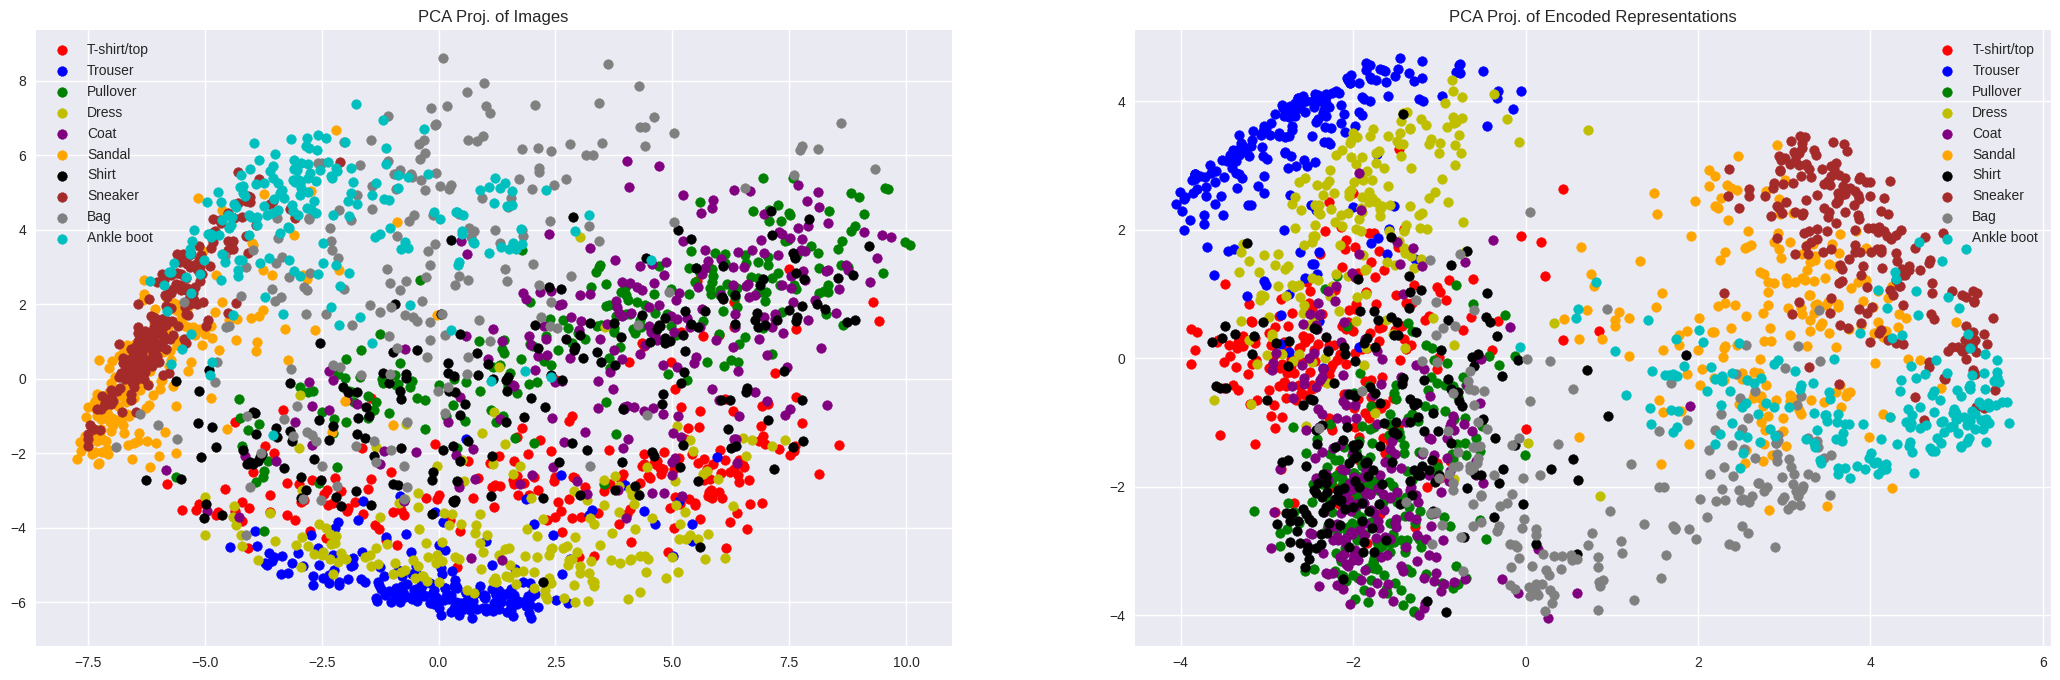

In [40]:
N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("PCA Proj. of Encoded Representations")
plt.show()

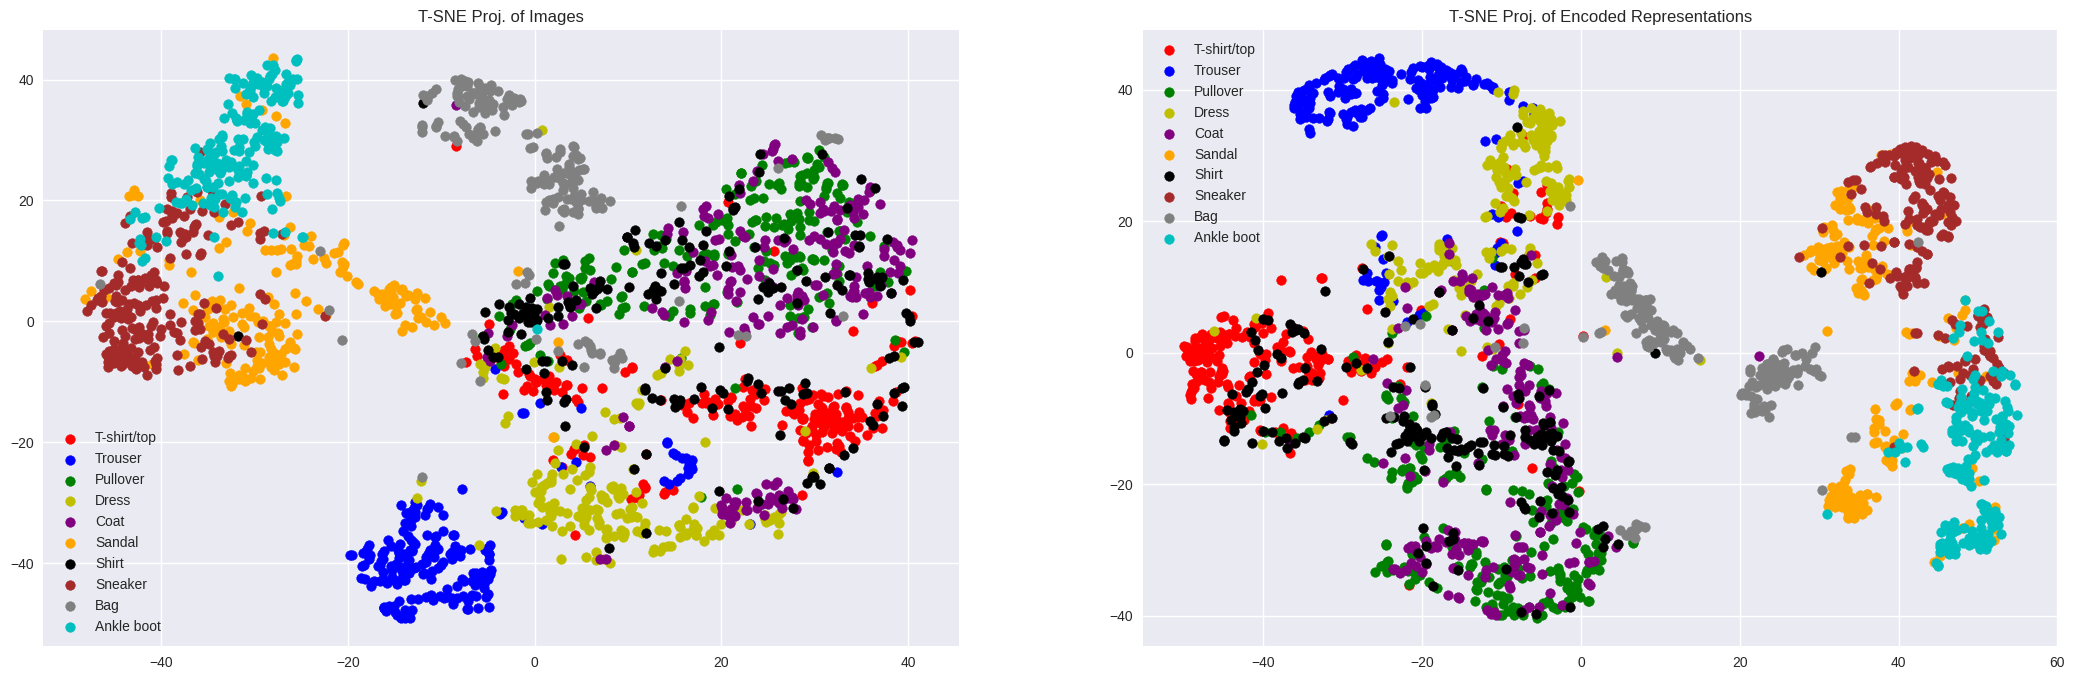

In [43]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

### Clustering

In [44]:
kmeans_imgs = KMeans(n_clusters=10, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=10, random_state=0).fit(latents)

/home/villar/anaconda3/envs/NimbroNet/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/villar/anaconda3/envs/NimbroNet/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [45]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [46]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=34.98%
Clustering latents achieves ARI=42.29%


In [47]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 64/1024  = 6.25%


## Can we generate new data by sampling from the Latent space?

In [48]:
# our latent space (bottleneck) is 64-dim
LATENT_DIM = 64
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs = ae.decoder(latents)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 32, 32)

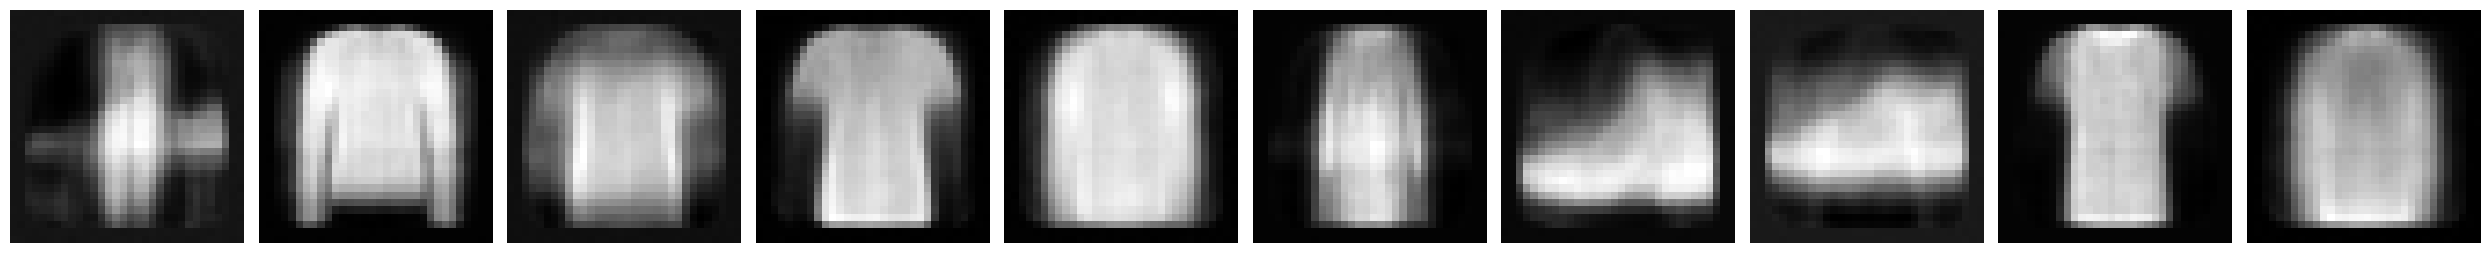

In [49]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

# 4: Variational Autoencoder

## Model

In [50]:
class VanillaVAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1, 32, 32), sizes=[1024, 128, 10], act="ReLU"):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation = get_act(act) 
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(sizes[-2], sizes[-1])
        self.fc_sigma = nn.Linear(sizes[-2], sizes[-1])
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-2):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-1] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)  # we can also predict the std directly, but this works best
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        
        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        
        return x_hat, (z, mu, log_var)

In [51]:
vae = VanillaVAE()

In [52]:
vae

VanillaVAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): Sigmoid()
  )
  (fc_mu): Linear(in_features=128, out_features=10, bias=True)
  (fc_sigma): Linear(in_features=128, out_features=10, bias=True)
)

## Training

In [53]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [54]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        kld_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            if writer is not None:
                grid = torchvision.utils.make_grid(images[:64].cpu())
                writer.add_image('images', grid, epoch)
                grid = torchvision.utils.make_grid(recons[:64].cpu())
                writer.add_image('output_images', grid, epoch)
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, savepath, writer, save_frequency=5, vis_frequency=2):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % vis_frequency == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)

        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch)
        writer.add_scalars(f'Loss/All_Valid_Loss', {"recons": recons_loss.item(), "kld": kld_loss.item()}, global_step=epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch)
        writer.add_scalars(f'Loss/Comb', {"train": mean_loss.item(), "valid": loss.item()}, global_step=epoch)
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld



In [55]:
vae = VanillaVAE(in_size=(1,32,32), sizes=[1024, 256, 128, 64, 2], act="ReLU")
vae = vae.to(device)

In [56]:
count_model_params(vae)

608516

In [57]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "vanilla_vae")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [58]:
savepath = "imgs/vanilla_vae"
model = vae

In [59]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [60]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, savepath=savepath,
        writer=writer
    )

Epoch 1 Iter 235: loss 0.03328. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 65.44it/s]


    Train loss: 0.04987
    Valid loss: 0.18895
       Valid loss recons: 0.18893
       Valid loss KL-D:   0.01954


Epoch 3 Iter 235: loss 0.02949. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 66.71it/s]

    Train loss: 0.02978
    Valid loss: 0.03079
       Valid loss recons: 0.02637
       Valid loss KL-D:   4.42366



Epoch 5 Iter 235: loss 0.02644. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 66.67it/s]

    Train loss: 0.0286
    Valid loss: 0.0292
       Valid loss recons: 0.02476
       Valid loss KL-D:   4.43307



Epoch 7 Iter 235: loss 0.02766. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 72.08it/s]

    Train loss: 0.02825
    Valid loss: 0.02839
       Valid loss recons: 0.02375
       Valid loss KL-D:   4.64323



Epoch 9 Iter 235: loss 0.02831. : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 66.51it/s]

    Train loss: 0.02776
    Valid loss: 0.02793
       Valid loss recons: 0.02329
       Valid loss KL-D:   4.63209



Epoch 10 Iter 235: loss 0.02927. : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 68.23it/s]

    Train loss: 0.02771
    Valid loss: 0.02892
       Valid loss recons: 0.0241
       Valid loss KL-D:   4.8167
Training completed


In [61]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

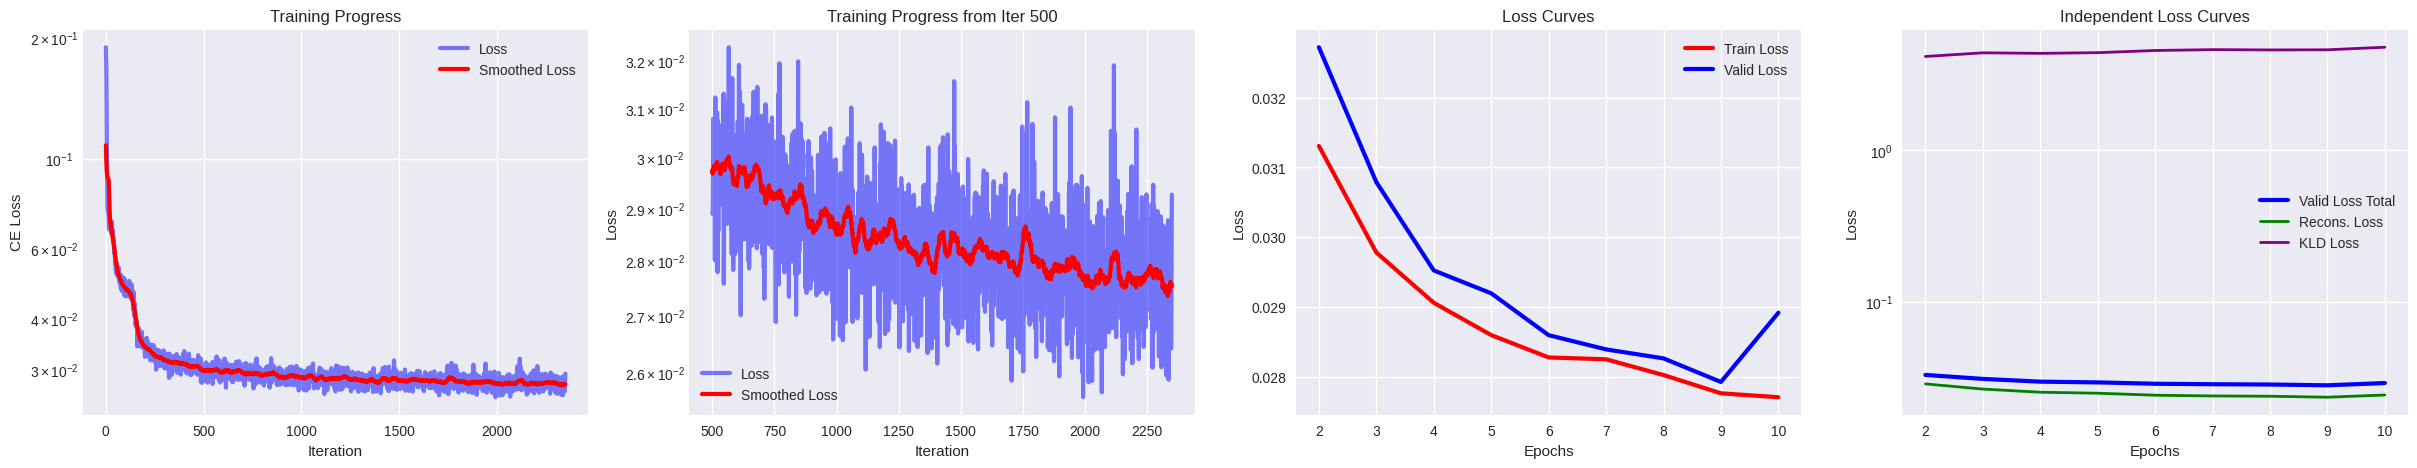

In [62]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,4)
fig.set_size_inches(30,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[3].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss Total", linewidth=3)
ax[3].plot(epochs[1:], val_loss_recons[1:], c="green", label="Recons. Loss", linewidth=2)
ax[3].plot(epochs[1:], val_loss_kld[1:], c="purple", label="KLD Loss", linewidth=2)
ax[3].legend(loc="best")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Loss")
ax[3].set_yscale("log")
ax[3].set_title("Independent Loss Curves")

plt.show()

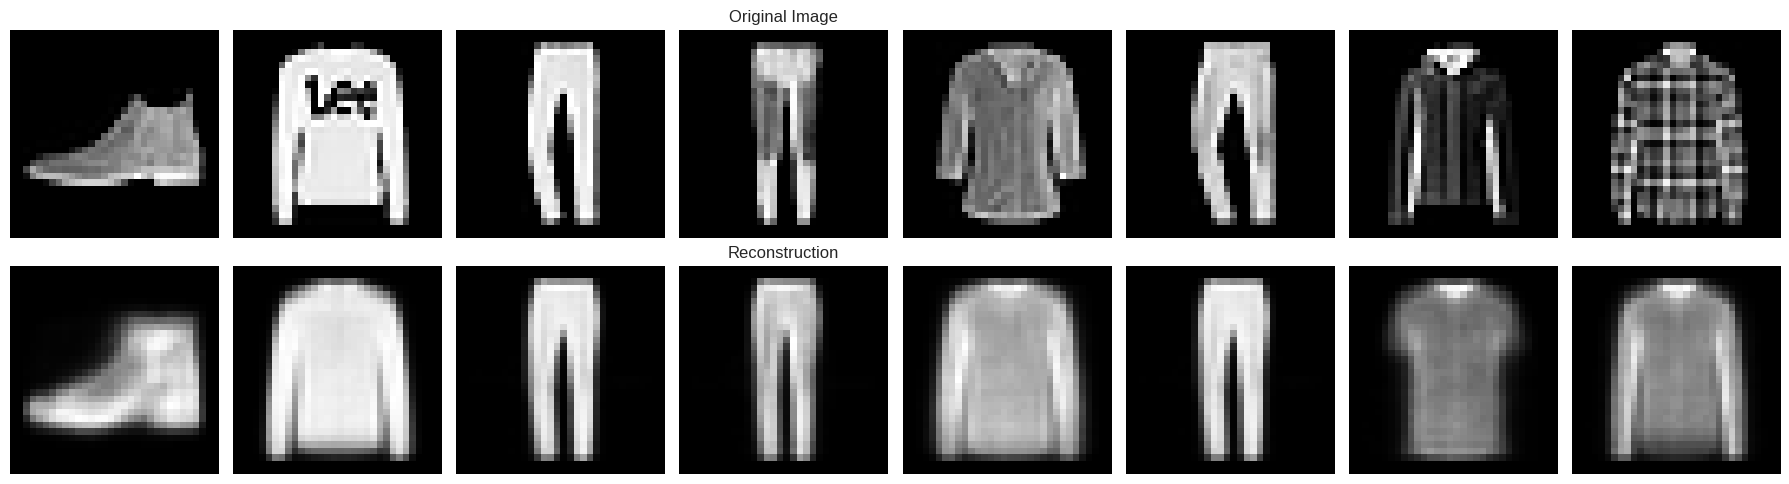

In [63]:
imgs, _ = next(iter(test_loader)) 

ae.eval()
with torch.no_grad():
    recons, _ = model(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

## Inference 

Generating new clothes from latent codes

In [64]:
if not os.path.exists("imgs/inferecence_vae"):
    os.makedirs("imgs/inferecence_vae")

In [65]:
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 2).to(device)
        sample = vae.decoder(z)
    
        save_image(sample.view(64, 1, 32, 32), f"imgs/inferecence_vae/inference_{i}.png")

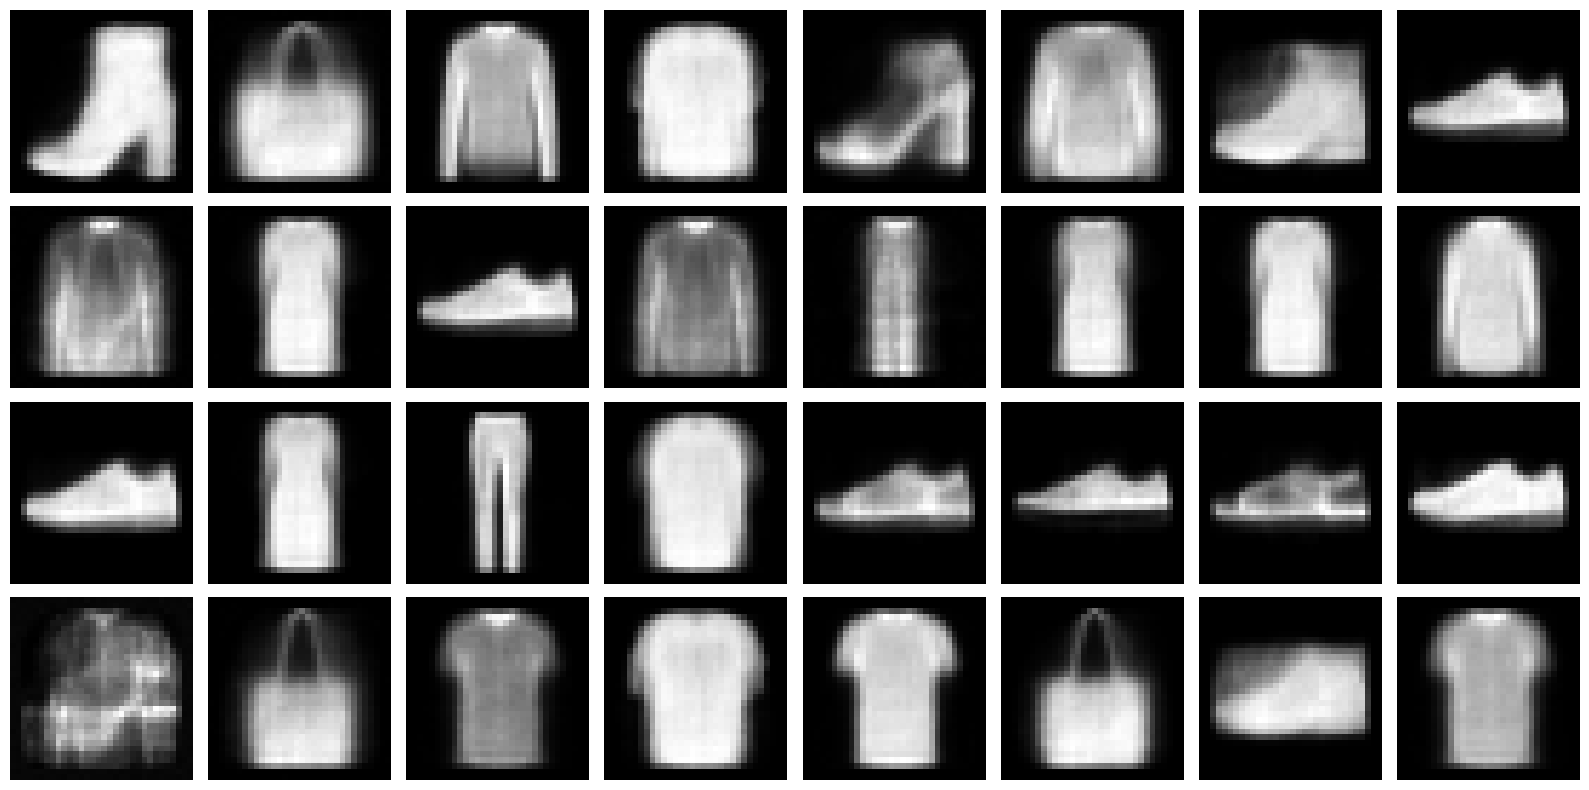

In [66]:
recons = sample.view(64, 1, 32, 32)
plt.figure(figsize=(8*2, 4*2))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(recons[i, 0].cpu(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Analysis

In [67]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

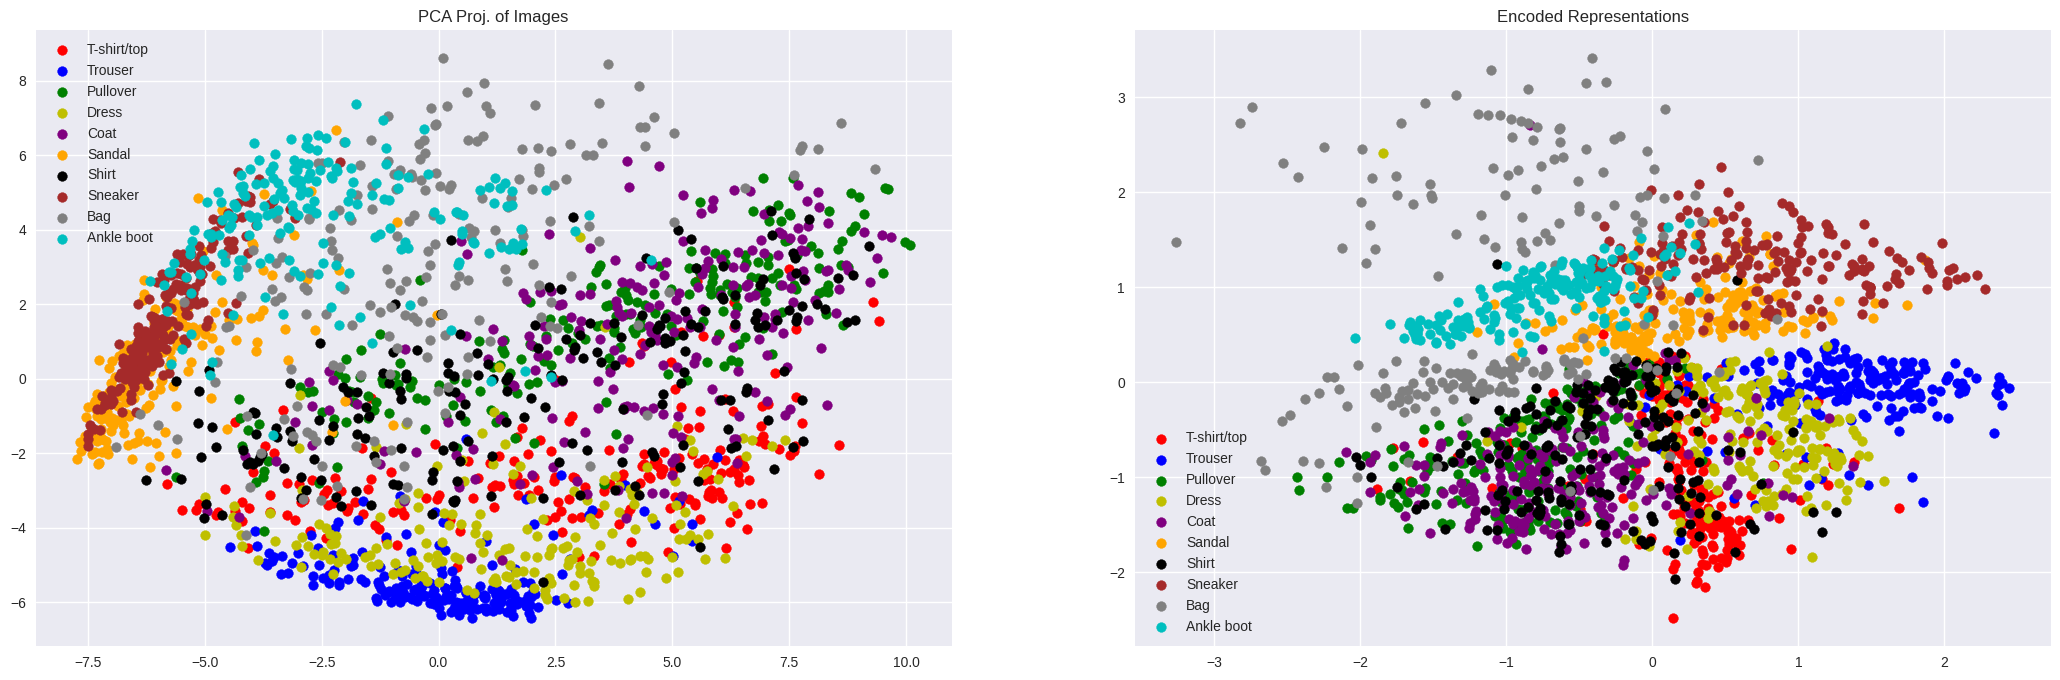

In [68]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)

# N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

## Interpolation

In [69]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")
    plt.show()

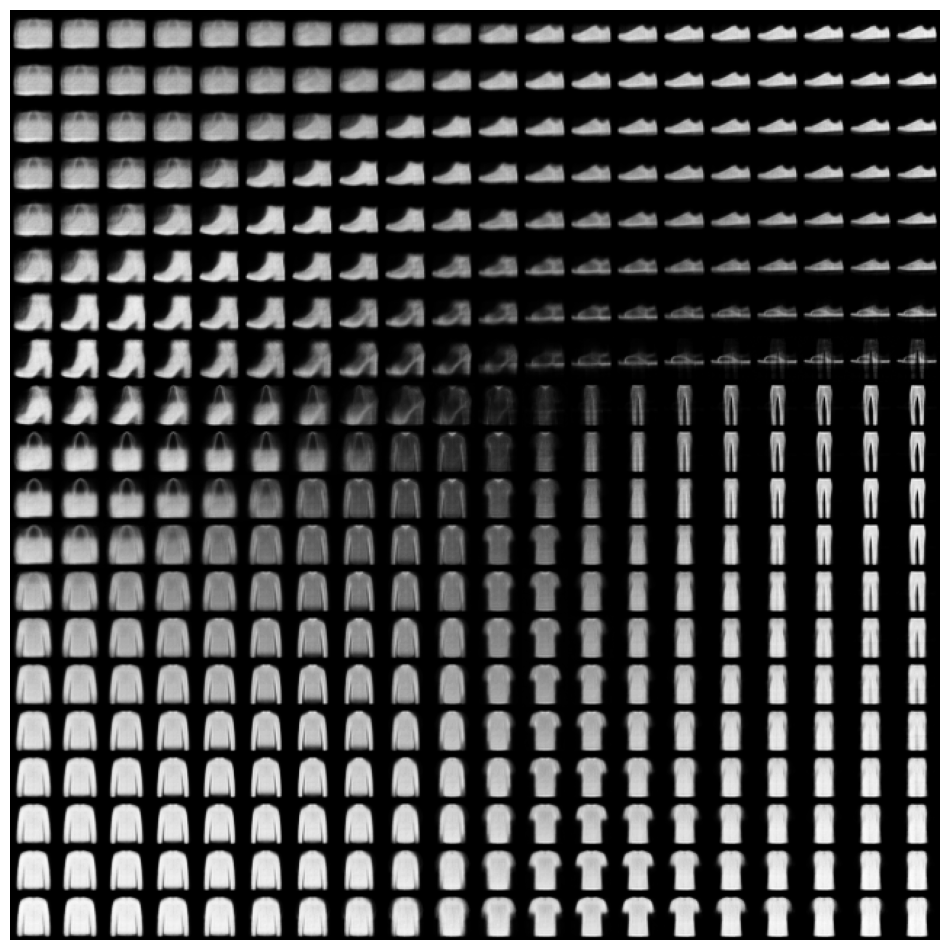

In [70]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=20)

In [71]:
img1 = test_dataset[1607][0]
img2 = test_dataset[1610][0]

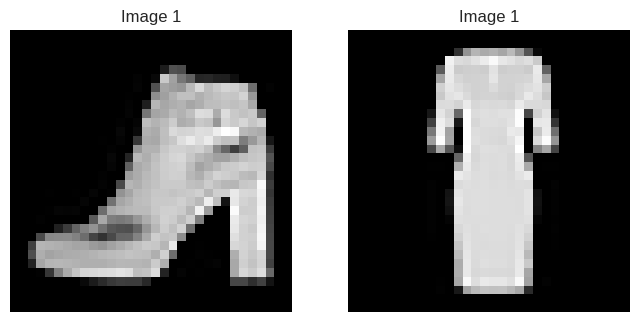

In [72]:
plt.subplot(1,2,1)
plt.imshow(img1[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(img2[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.show()

In [73]:
with torch.no_grad():
    encoded = model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = model.fc_mu(encoded), model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

In [74]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """
    
    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    decoded = model.decoder (z)
    decoded_imgs = decoded.cpu().view(-1,32,32)
    return decoded_imgs

In [75]:
decoded_imgs = sample_interpolation(model, latent2, latent1, N=18)

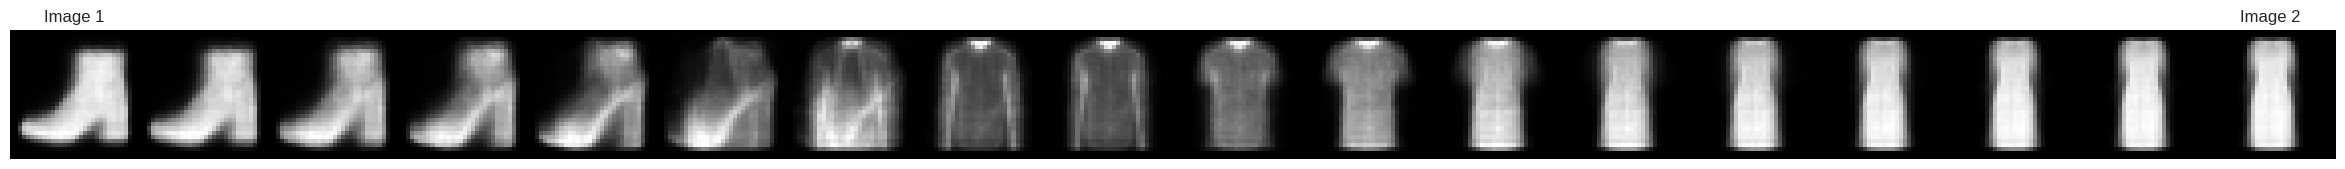

In [76]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img, cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

# Assignment 4
 - a) We will be working with the **AFHQ (Animal Faces-HQ)** dataset: https://github.com/clovaai/stargan-v2
    - Approx 15.000 images of animal faces (cat, dog, tiger, ...)
    - Downsample the images to 64x64
 - b) Write **Convolutional** Variational Autoencoder (ConvVAE)
      - Use Conv. layers for encoder and Transposed-Conv. layers for decoder.
      - You are only allowed to use linear layers for estimating the mean and standard deviation. Everything else should be convolutional.
 - c) Investigate the importance of the KL-divergence weight. For this purpose, train multiple models (at least 4) using different weighting values and investigate how this value affects the generation performance.
 - d) Generate new images by sampling latent vectors, investigate latent space and visualize some interpolations.
 - e) Compare the models from b) and c)
     - Qualitative comparison. Which images look better?
     - Quantitative comparison between models using the Fréchet Inception Distance: https://arxiv.org/abs/1706.08500
     - Log generated images and losses into the Tensorboard/W&B
     
     
**Extra Point:**
 - Extend your ConvVAE for Image generation conditioned on a given class. The AFHQ dataset has 3 classes: 'cat', 'dog', and 'wildlife'
 - Train your Conditional-ConvVAE
 - Show that you can generate images conditioned on a label
 - Tutorial: https://ijdykeman.github.io/ml/2016/12/21/cvae.html

#### **Due Date**: Monday 2nd June at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment4 + Group Name**
####  Send me the following: Jupyter Notebook after running, Jupyter export as **html**, Tensorboard logs, and any other .py files or images used.

#### **Next Session** Wednesday 4th June

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://github.com/lyeoni/pytorch-mnist-VAE
 - https://towardsdatascience.com/reparameterization-trick-126062cfd3c3
 - https://ijdykeman.github.io/ml/2016/12/21/cvae.html

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  